# **Main Results Summary Dashboard:**

Data Analysis:
- The industry with highest income is OIL, second is FINANCE and third is WEB.
- For every jobtype, workers with higher degree have a higher income.
- The highest paid job is CEO, while the least paid is JANITOR.
- For every jobtype, Engineering, Businees and Math are the majors which lead to higher income.
- The average income of workers with no experience differs a lot among the jobtype:
    - CEO has a base average income around 120k\\$, CFO around 110k\\$ while Janitor only 47k\\$.
- Among all jobs, mean, median and mode salary are respectively 116k\\$, 114k\\$ and 108k\\$. They do not coincide due to the right skeweness of the salary distribution.

Prediction :
- We can see that the algorithm predicts better salaries lower than 130k\\$, and start to understimate salaries over 175k\\$. This could be due to the right skeweness of the salary distribution.<br>
Overall, the results are satifying in both terms of RMSE and R2. Further improvements could be achieved by a proper hyperparameter tuning and feature engineering on the data.

<img src="https://i.imgur.com/fBHkdi4.png" width="1000px">

In [1]:
!pip install pyspark

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/salarypredictions/train_dataset.csv
/kaggle/input/salarypredictions/test_dataset.csv
/kaggle/input/salarypredictions/train_salaries.csv


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.style.use('ggplot')
sns.set_style("whitegrid")

from scipy import stats

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.regression import GBTRegressor

In [5]:
conf = SparkConf().set("spark.ui.showConsoleProgress", "false")
sc = SparkContext(appName="Pyspark, SQL and Machine Learning for salary prediction", conf=conf)
sc

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/03 10:00:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=Pyspark, SQL and Machine Learning for salary prediction>

In [6]:
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("ERROR")

In [7]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [8]:
path = '/kaggle/input/salarypredictions/'
df_path = path + 'train_dataset.csv'
df1_path = path + 'train_salaries.csv'

# Dataset Loading and first analysis

In [9]:
df1 = spark.read.csv(df_path, header=True).cache()

In [10]:
df2 = spark.read.csv(df1_path, header=True).cache()

In [11]:
df1.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [12]:
df2.show(5)

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
+----------------+------+
only showing top 5 rows



We can also get informations about the column types:

In [13]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: string (nullable = true)
 |-- milesFromMetropolis: string (nullable = true)



In [14]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)



By printing the df schema, we can see that some features such as salary, yearsExperience and milesFromMetropolis should be converted to integer type!

In [15]:
df1 = df1.withColumn("yearsExperience",df1.yearsExperience.cast('int'))
df1 = df1.withColumn("milesFromMetropolis",df1.milesFromMetropolis.cast('int'))

In [16]:
df2 = df2.withColumn("salary", df2.salary.cast('int'))

In [17]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



In [18]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)



We successfully changed the data type of the three mentioned columns.

Before starting the analysis, we will join the two dataframes on jobid. If we join the two dataframe as is, we will have two identical columns jobId, which will create ambiguity. For this reason we will rename the JobId column in the second dataframe, so that we can drop it after the join without creating ambiguity with the jobId column of the first dataframe.

In [19]:
df2 = df2.withColumnRenamed('jobId', 'job_id')

In [20]:
df = df1.join(df2, df1.jobId==df2.job_id)

In [21]:
df = df.drop('job_id')

In [22]:
df.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|   101|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|   137|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|   142|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|   163|
+----------------+---------+--------------+-----------+-

# Duplicated data check

In [23]:
df_dup=df.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")
df_dup.drop('count').show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



Good news, apparently there are no duplicate rows!

# Missing Values check

In [24]:
df.show(10)

+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407693|   COMP15|           CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407695|   COMP20|       JANITOR|HIGH_SCHOOL|     NONE|EDUCATION|              1|                 54|    31|
|JOB1362684407696|   COMP41|VICE_PRESIDENT|  BACHELORS|CHEMISTRY|     AUTO|             17|                 68|   104|
|JOB1362684407700|   COMP54|        JUNIOR|    M

We can see that some columns have 'NONE' values, are these missing values?

In [25]:
print('Number of missing values for jobType: {}'.format(df.filter(df.jobType=='NONE').count()))
print('Number of missing values for degree: {}'.format(df.filter(df.degree=='NONE').count()))
print('Number of missing values for major: {}'.format(df.filter(df.major=='NONE').count()))
print('Number of missing values for industry: {}'.format(df.filter(df.industry=='NONE').count()))

Number of missing values for jobType: 0
Number of missing values for degree: 236854
Number of missing values for major: 532355
Number of missing values for industry: 0


Acutally they are not missing values! They indicate that the worker do not have a degree or major for example. We won't drop these values.

# Dataset Analayis

We can get some basic insights on the numerical columns by calling the describe method

In [26]:
df.describe(['yearsExperience', 'milesFromMetropolis','salary']).show()

+-------+-----------------+-------------------+-----------------+
|summary|  yearsExperience|milesFromMetropolis|           salary|
+-------+-----------------+-------------------+-----------------+
|  count|          1000000|            1000000|          1000000|
|   mean|        11.992386|           49.52926|       116.061818|
| stddev|7.212390868885673| 28.877732628720036|38.71793638113296|
|    min|                0|                  0|                0|
|    max|               24|                 99|              301|
+-------+-----------------+-------------------+-----------------+



The minimum salary looks to be 0, is this related to volounteering jobs? This will be investigated later!

# Q1 Which is the highest paid job?

In order to perform SQL queries on the dataset, we must create a table based on the spark dataframe, as follows:

In [27]:
df.createOrReplaceTempView("data")

Then we can perform SQL queries!

In [28]:
spark.sql('''
    SELECT salary, jobtype, industry
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



**The highest paid jobs are CFO (Chief financial officer) and CTO (Chief technology officer ) in the OIL industry, with a salary of 301k$.**

# Q2 Which are the TOP 20 jobs in terms of highest salary?

In [29]:
df_q2 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
          FROM data
          ORDER BY salary DESC
          LIMIT 20''')
df_q2.show(20)

+------+-------+--------+----+
|salary|jobtype|industry|Rank|
+------+-------+--------+----+
|   301|    CFO|     OIL|   1|
|   301|    CTO|     OIL|   1|
|   298|    CEO|     OIL|   3|
|   294|    CEO|     OIL|   4|
|   294|    CEO| FINANCE|   1|
|   293|    CEO|     OIL|   5|
|   293|    CEO| FINANCE|   2|
|   292|    CEO| FINANCE|   3|
|   292|    CTO| FINANCE|   3|
|   290|    CEO|     WEB|   1|
|   289|    CTO|     WEB|   2|
|   289|    CFO|     OIL|   6|
|   289|    CEO| FINANCE|   5|
|   288|    CFO| FINANCE|   6|
|   288|    CFO| FINANCE|   6|
|   287|    CEO|     OIL|   7|
|   287|    CEO| FINANCE|   8|
|   286|    CEO|     OIL|   8|
|   286|    CTO| FINANCE|   9|
|   286|    CEO| FINANCE|   9|
+------+-------+--------+----+



**We can find the previous result (obtained with a subquery) of the highest paid jobs, in particular we can see that 8 of the TOP20 paid jobs are in the OIL industry(5 of them in the TOP10), 10  are from FINANCE and 2 are from WEB. We also added a Rank column to improve the readability of the result.**

# Q3 Which is the least paid job?

In [30]:
spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''').show()

+------+--------------+---------+----+
|salary|       jobtype| industry|Rank|
+------+--------------+---------+----+
|     0|VICE_PRESIDENT|      WEB|   1|
|     0|        JUNIOR|     AUTO|   1|
|     0|           CTO|     AUTO|   1|
|     0|       MANAGER|  FINANCE|   1|
|     0|        JUNIOR|      OIL|   1|
|    17|       JANITOR|EDUCATION|   1|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    20|       JANITOR|EDUCATION|  15|
+------+--------------+---------+----+
only showing top 20 rows



We can clearly see that the jobs with 0\\$ salary are probably missing values, since they are related for example to OIL and WEB industries, which are very weel paid (as seen before). Moreover, there is also a 'vice president' job, which is impossible to have 0$ salary. We will drop these rows. <br>


In [31]:
df = df.where("salary != 0")

Then, we also need to reload the table since we updated the dataframe df.

In [32]:
df.createOrReplaceTempView("data")

In [33]:
df_q3 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''')
df_q3.show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|    17|JANITOR|EDUCATION|   1|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
+------+-------+---------+----+
only showing top 20 rows



**We can see that now the lowest paid job is 'janitor', with a minimum salary of 17k$.**

# Q4 Which are the TOP 3 industries in terms of highest salary?

In [34]:
df_q4 = spark.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
df_q4.show(10)

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



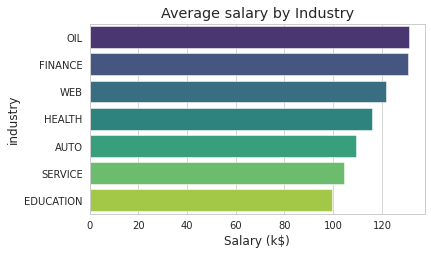

In [35]:
df_p = df_q4.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y='industry', x = 'average_salary', data=df_p, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

**We can see first two industries are OIL and FINANCE, with have a very similar average salary of 130k\\$. The third industry in terms of highest salary is WEB. We could expect this result by looking at the Q1 query result.**

# Q5 Do workers with more years of experience get paid more?

In [36]:
df_q5 = spark.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''') 
df_q5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CFO|     OIL|             23|
|   301|    CTO|     OIL|             24|
|   298|    CEO|     OIL|             22|
|   294|    CEO|     OIL|             19|
|   294|    CEO| FINANCE|             24|
|   293|    CEO| FINANCE|             16|
|   293|    CEO|     OIL|             24|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CFO|     OIL|             23|
|   289|    CTO|     WEB|             24|
|   289|    CEO| FINANCE|             23|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO| FINANCE|             19|
|   287|    CEO|     OIL|             22|
|   286|    CEO| FINANCE|             24|
|   286|    CTO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
+------+-------+--------+---------

In order to improve the readability of the results, we will plot salary VS jobtype. Before doing so, we should check the different jobtypes in the dataframe:

In [37]:
df_q5.groupBy('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [38]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']

Next we need to convert the extracted dataframe by SQL query Q5 into a pandas dataframe:

In [39]:
df_p = df_q5.toPandas()

Finally we can create the plots with a for loop, including a linear regression to improve the readability of the plots.

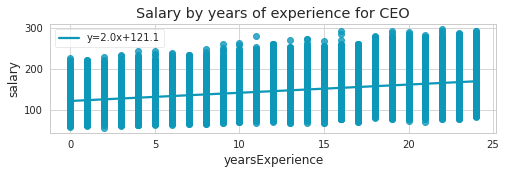

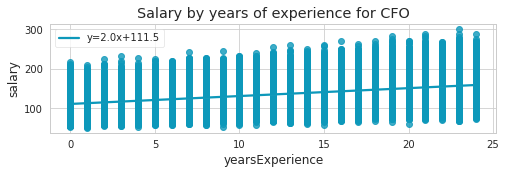

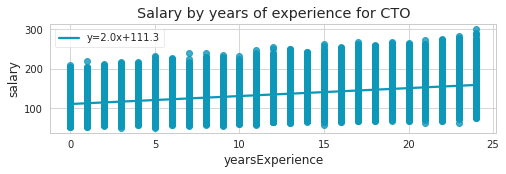

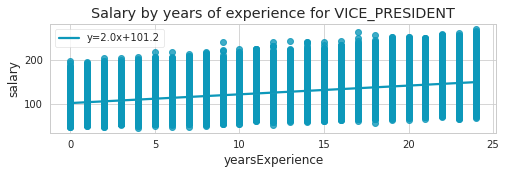

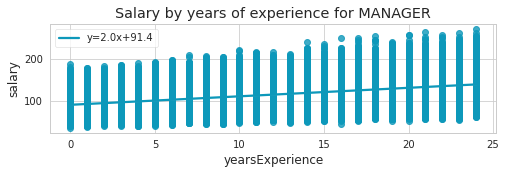

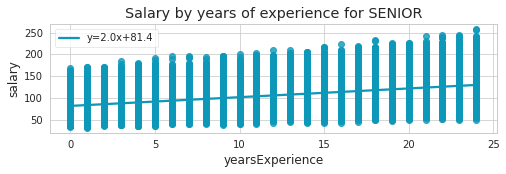

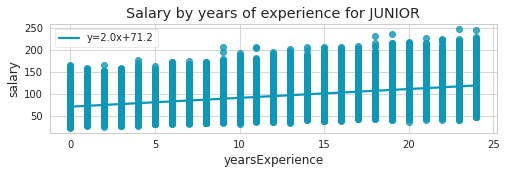

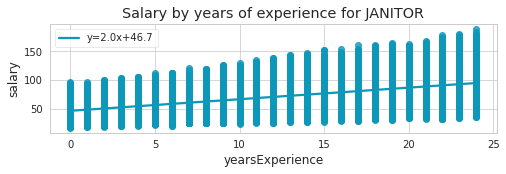

In [40]:
slope_list = []  #to save the slopes of the regression lines
intercept_list = [] #to save the intercepts of the regression lines

for job in job_list:
    df_x = df_p.loc[df_p['jobtype']==job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + job)
    plt.show()

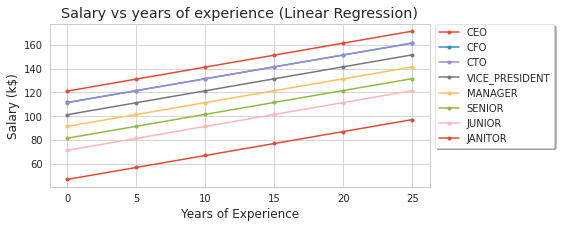

In [41]:
X = np.array([0, 5, 10, 15, 20, 25])
plt.figure(figsize=(6.8,3))
for i in range(8):
    plt.plot(X, slope_list[i]*X+intercept_list[i],label=job_list[i], marker='.')
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fancybox=True, shadow=True)
plt.ylabel('Salary (k$)')
plt.xlabel('Years of Experience')
plt.title('Salary vs years of experience (Linear Regression)')
plt.show()

**We can see an increasing trend between years of experience and salary among all different jobs: this means that more years of experience lead to higher salaries for all the job positions. 
By looking at the slope and intercept for each linear model, we can see that the slope is rounded to 2.0 for all the positions: this means that, on average, all these jobs see an increase of salary by 2000\\$ annually. The difference is the intercept, which can be interpreted as the average salary of a worker with 0 years of experience. In particular we can see an intercept value of 121.5k\\$ for CEO and 46.7k\\$ for janitor.**

# Q6 Do workers with higher degrees have better paid jobs?

In [42]:
df_q6 = spark.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    18|JANITOR|
|       NONE|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



We can see some NONE values in the degree column: we will drop the rows with no degree.

In [43]:
df_q6 = df_q6.replace('NONE',None)

In [44]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       null|    17|JANITOR|
|       null|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       null|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [45]:
df_q6 = df_q6.na.drop()

In [46]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



Then, as seen for Q5, we will extract a list of different degrees:

In [47]:
df_q6.groupBy('degree').count().show()

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|HIGH_SCHOOL|236975|
|   DOCTORAL|175362|
+-----------+------+



In [48]:
degrees_list = ['HIGH_SCHOOL','BACHELORS','DOCTORAL','MASTERS']

Finally we can convert the extracted dataframe by SQL query 'Q6' to a pandas dataframe in order to plot the desired result.

In [49]:
df_p = df_q6.toPandas()

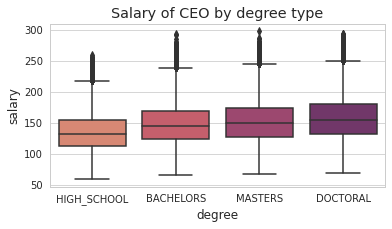

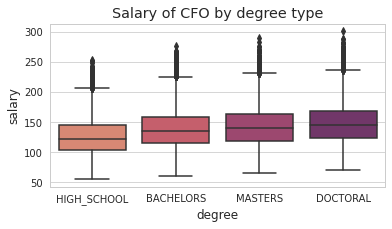

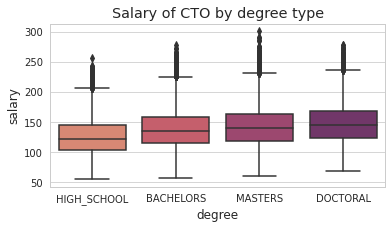

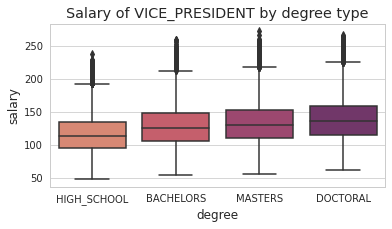

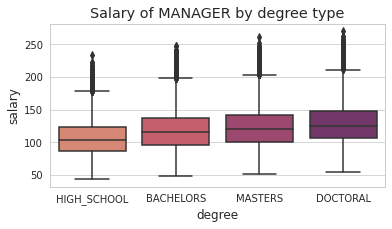

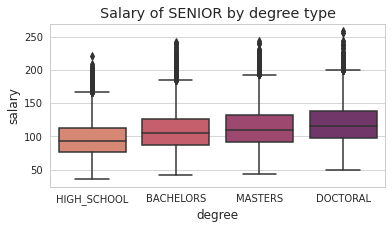

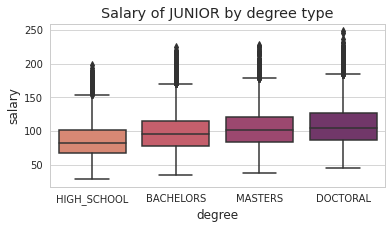

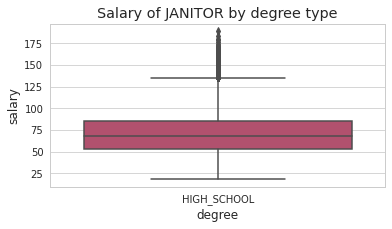

In [50]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(6,3))
  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')
  plt.title('Salary of ' + job + ' by degree type')
  plt.show()

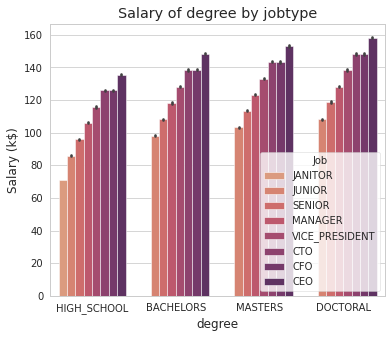

In [51]:
plt.figure(figsize=(6,5))
sns.barplot(x='degree', y = 'salary', data=df_p, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

**It looks like for all job types in this dataset, higher educated workers get paid more. In particular we can see a higher difference of salaries between 'high school' and 'bachelor'.
Lastly is it interesting to notice that in case of JANITOR as a jobtype, there are only people with a High school education.**

# Q7 Does the major affects the salary?

In [52]:
df_q7 = spark.sql('''
                  SELECT jobtype, degree, major, salary
                  FROM data
                  ORDER BY salary''')
df_q7.show(5)

+-------+-----------+-----+------+
|jobtype|     degree|major|salary|
+-------+-----------+-----+------+
|JANITOR|       NONE| NONE|    17|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    19|
+-------+-----------+-----+------+
only showing top 5 rows



We still have NONE values in degree and also in major (note: if the degree=High school, of course the major should be NONE!), we will drop these values!

In [53]:
df_q7 = df_q7.replace('NONE',None)
df_q7 = df_q7.na.drop()

In [54]:
df_q7.groupBy('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|       MATH|57800|
|    COMPSCI|58382|
| LITERATURE|58684|
+-----------+-----+



In [55]:
df_q7.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO|66885|
|        JUNIOR|66465|
|           CFO|66427|
|           CEO|66754|
|       MANAGER|66832|
|VICE_PRESIDENT|66771|
|        SENIOR|67508|
+--------------+-----+



In this dataframe there is no JANITOR as a jobtype: it means that people with 'janitor' as a jobtype in the dataset all have 'High school' as degree, and so no major (as stated in the previous query Q6). We need to define a new list of jobs without janitor for the following plots!

In [56]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [57]:
df_p = df_q7.toPandas()

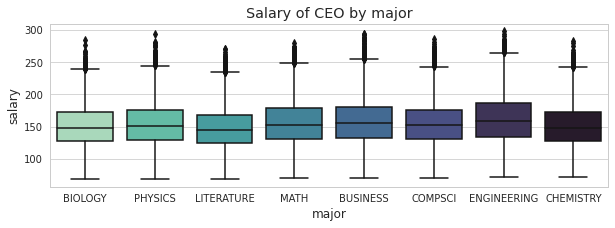

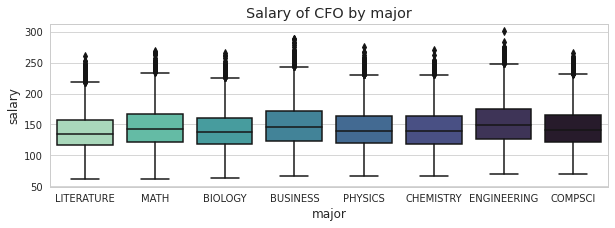

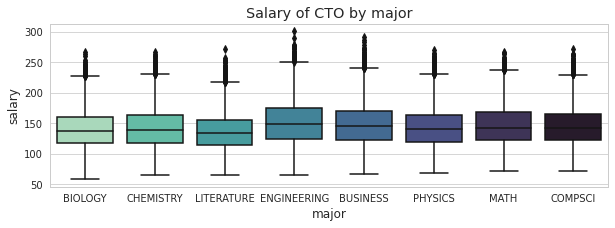

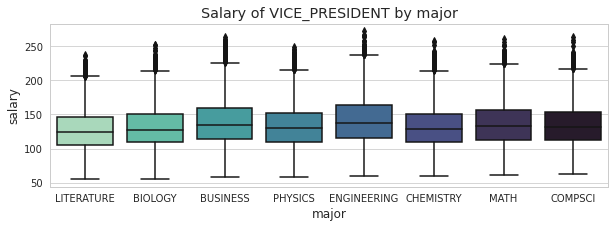

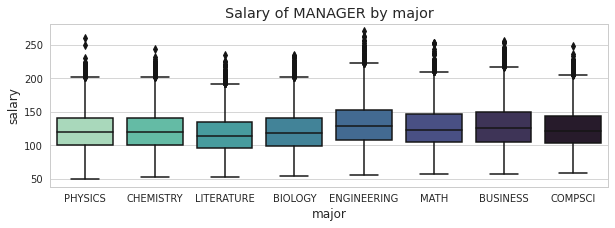

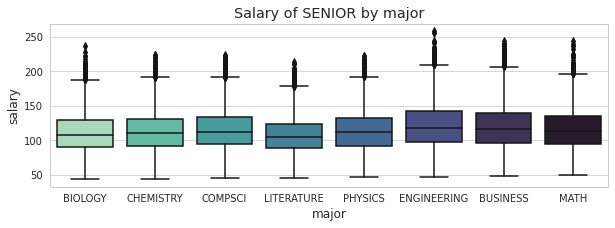

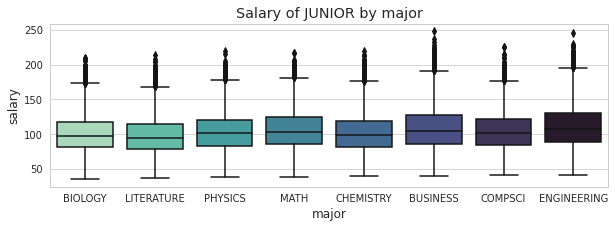

In [58]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(10,3))
  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')
  plt.title('Salary of ' + job + ' by major')
  plt.show()

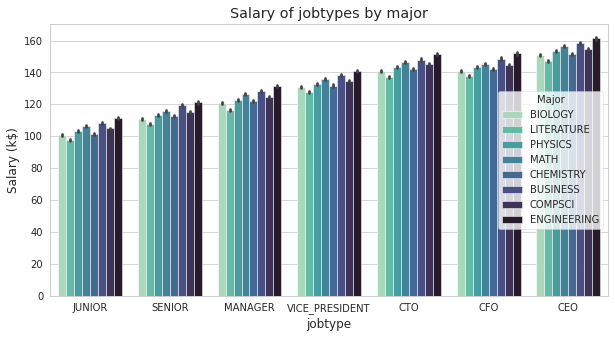

In [59]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobtype', y = 'salary', data=df_p, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

**We can see that engineering is the major the major of workers with higher salaries, business is the second and while literature is the major of workers with the lowest paid jobs.**